In [3]:
#conda install -c conda-forge ta-lib

In [1]:
import yfinance as yf, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xlrd, re
import datetime, pickle, math, openpyxl
from tqdm.notebook import tqdm_notebook
import talib

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

# Derive Target Pool of Tickers

In [80]:
#Import most recent Nasdaq scraped data
nasdaq=pd.read_excel('nasdaq_data_upto_2022-07-15.xlsx')

In [6]:
#Check total unique tickers
len(nasdaq.Name.unique())

2993

In [43]:
#Check total number of ETF's in above list
etf_lists=[re.findall('.*ETF',x) for x in nasdaq.Name.unique()]
unique_etf=[y[0] for y in etf_lists if len(y)>0]
unique_etf_symbols=nasdaq[nasdaq.Name.isin(unique_etf)].Symbol.unique()
#re.match('.*ETF',unique_etf[0]) is not None
len(unique_etf)

371

In [44]:
#Check total number of non-ETF funds in above list
funds_lists=[re.findall('.*fund',x.lower()) for x in nasdaq.Name.unique()]
unique_funds=[y[0] for y in funds_lists if len(y)>0]
nasdaq["Fund"]=nasdaq.Name.apply(lambda x:False if re.match('.*fund',x.lower()) is None else True)
unique_funds_symbols=nasdaq[nasdaq.Fund==True].Symbol.unique()
len(unique_funds)

288

In [131]:
len(unique_funds_symbols)

289

In [7]:
#Filter 1 = Tickers which have paid dividend less than 8 times from 2014 till date
filter1=nasdaq.Symbol.value_counts().to_frame()[nasdaq.Symbol.value_counts().to_frame().Symbol<8].index

In [8]:
#removing tickers in filter1 from nasdaq data
symbol=set(nasdaq.Symbol.unique())
symbol1=symbol-set(filter1)

In [9]:
#Remove tickers in filter1 from data
nasdaq1=nasdaq[nasdaq.Symbol.isin(symbol1)]

In [83]:
#Thesis Pool of Stocks; takes 20 minutes to execute for 3 yrs of data
#Tickers from nasdaq1 which have avg yield & avg traded volume  from 2018-2021 higher than my desired thresholds
target_pool=[]
yield_threshold=0.004
daily_price_volume_threshold=0.001
error_tickers=[]

for ticker in tqdm_notebook(nasdaq1.Symbol.unique()):
    try:
        ticker_data=yf.Ticker(ticker)
        data_3yrs=ticker_data.history(start="2018-01-01", end="2021-12-31")
        data_3yrs['Dividends/Pc']=data_3yrs.Dividends/data_3yrs.Close
        if len(data_3yrs[data_3yrs.Dividends!=0])>0: #if yfinance data has non-zero dividend dates; ideally it hould for all
            if data_3yrs[data_3yrs.Dividends>0.0]['Dividends/Pc'].mean()>yield_threshold: #tickers higher than yield threshold
                avg_price_vol_sumproduct=(data_3yrs.Volume*data_3yrs.Close).mean()
                if 75000/avg_price_vol_sumproduct<daily_price_volume_threshold: #tickers higher than volume threshold
                    target_pool.append(ticker)
    except:
        error_tickers.append(ticker)

- WSO.B: No data found, symbol may be delisted
- AKO.A: No data found, symbol may be delisted
- AKO.B: No data found, symbol may be delisted
- LEN.B: No data found for this date range, symbol may be delisted
- GRP.U: No data found, symbol may be delisted
- TGR: Data doesn't exist for startDate = 1514745000, endDate = 1640889000
- DO: Data doesn't exist for startDate = 1514745000, endDate = 1640889000
- BF.B: No data found for this date range, symbol may be delisted
- BF.A: No data found, symbol may be delisted
- CRD.B: No data found, symbol may be delisted
- CRD.A: No data found, symbol may be delisted
- EE: Data doesn't exist for startDate = 1514745000, endDate = 1640889000
- VR: Data doesn't exist for startDate = 1514745000, endDate = 1640889000
- GEF.B: No data found for this date range, symbol may be delisted
- MKC.V: No data found, symbol may be delisted
- HEI.A: No data found, symbol may be delisted
- STZ.B: No data found for this date range, symbol may be delisted
- MOG.A: No da

In [87]:
#Check how many tickers' data gave error
len(error_tickers)/len(nasdaq1.Symbol.unique())

0.009023146331894862

**The fraction of tickers giving error in data from yfinance is 0.009 or less than 1%. I will not consider these in subsequent analysis.**

In [88]:
len(target_pool)

329

**Thus, a total of 329 stocks are identified as the target pool for subsequent analysis**

In [85]:
#Saving pool of stocks
pd.Series(target_pool).to_excel(f"target_pool_thesis_{str(datetime.date.today())}.xlsx", index=False)

In [90]:
#Importing old pool of stocks
target_pool_old=pd.read_excel("target_pool_thesis_2022-07-12.xlsx")

In [133]:
#Checking how many are ETFs and Funds
print("Funds in target pool are {}; ETFs in target pool are {}".
      format(len(set(unique_funds_symbols) & set(target_pool)),len(set(unique_etf_symbols) & set(target_pool))))

Funds in target pool are 2; ETFs in target pool are 7


**There are 9 ETF's and Funds in the pool of 329 tickers; the remaining 320 are stocks**

### I will now check the calendar distribution of target pool of stocks to see if its well distributed throughout the year ensuring opportunity to trade on maximum days in a year

In [81]:
nasdaq.columns

Index(['Input Date', 'Name', 'Symbol', 'Ex-Dividend Date', 'Payment Date',
       'Record Date', 'Dividend', 'Indicated Annual Dividend',
       'Announcement Date'],
      dtype='object')

In [82]:
calndr_distbn=nasdaq[['Symbol','Ex-Dividend Date']]

In [83]:
calndr_distbn['Ex-Dividend Date']=pd.to_datetime(calndr_distbn['Ex-Dividend Date'])

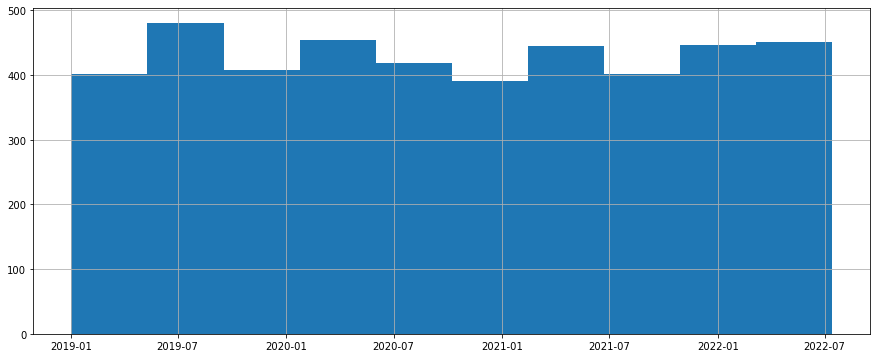

In [84]:
calndr_distbn[calndr_distbn.Symbol.apply(lambda x:x in target_pool)][calndr_distbn[calndr_distbn.Symbol.apply(lambda x:x in target_pool)]['Ex-Dividend Date']>pd.to_datetime(datetime.date(2019,1,1))]['Ex-Dividend Date'].hist(figsize=(15, 6))
plt.show()

In [85]:
freq_df=calndr_distbn[calndr_distbn.Symbol.apply(lambda x:x in target_pool)][calndr_distbn[calndr_distbn.Symbol.apply(lambda x:x in target_pool)]['Ex-Dividend Date']>pd.to_datetime(datetime.date(2019,1,1))]['Ex-Dividend Date'].value_counts().rename_axis('Ex-Dividend Date').reset_index(name='counts')

<AxesSubplot:xlabel='Ex-Dividend Date'>

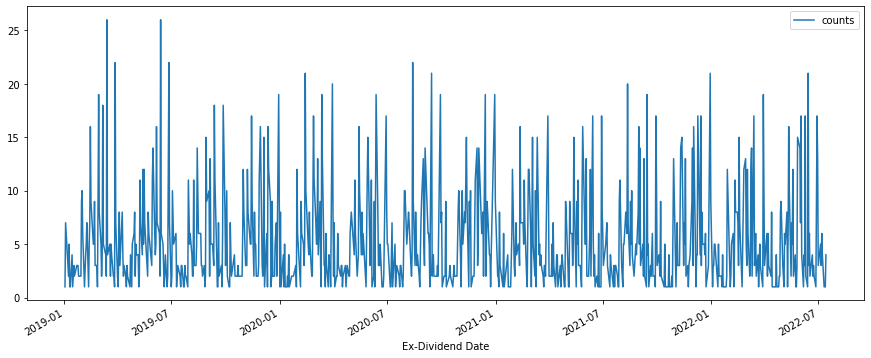

In [88]:
freq_df.sort_values(by='Ex-Dividend Date')[freq_df.sort_values(by='Ex-Dividend Date')['Ex-Dividend Date']>pd.to_datetime(datetime.date(2019,1,1))].plot(x='Ex-Dividend Date',y='counts',figsize=(15,6))

In [97]:
def exdd_ticker_count(start_date, end_date):
    counter_df=freq_df.sort_values(by='Ex-Dividend Date')[(freq_df.sort_values(by='Ex-Dividend Date')['Ex-Dividend Date']>start_date) & (freq_df.sort_values(by='Ex-Dividend Date')['Ex-Dividend Date']<end_date)]
    counter_df.plot(x='Ex-Dividend Date',y='counts',figsize=(15,6))
    plt.show()
    print("Days of at least 1 ex_dividend date in year = {}".format(len(counter_df[counter_df.counts>0].counts)))

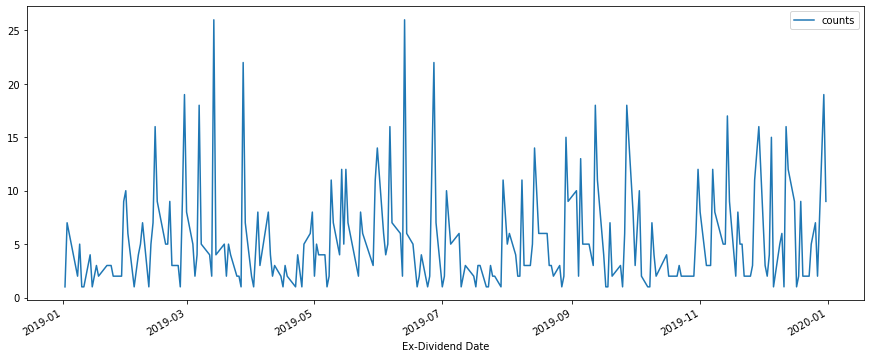

Days of at least 1 ex_dividend date in year = 230


In [98]:
#Count of ex-dividend stocks per day in 2019
exdd_ticker_count(pd.to_datetime(datetime.date(2019,1,1)),pd.to_datetime(datetime.date(2020,1,1)))

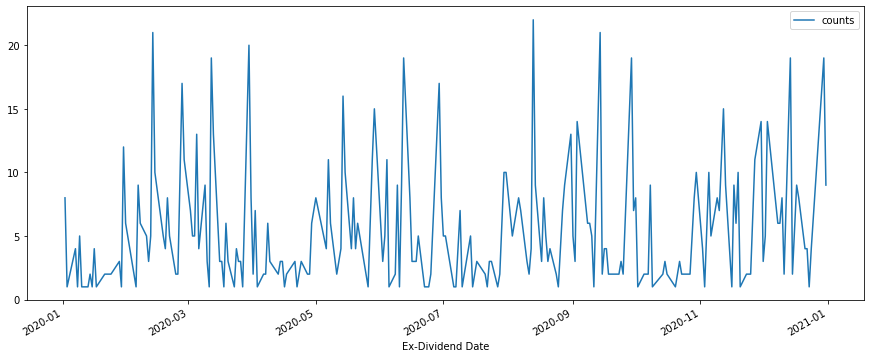

Days of at least 1 ex_dividend date in year = 223


In [100]:
#Count of ex-dividend stocks per day in 2020
exdd_ticker_count(pd.to_datetime(datetime.date(2020,1,1)),pd.to_datetime(datetime.date(2021,1,1)))

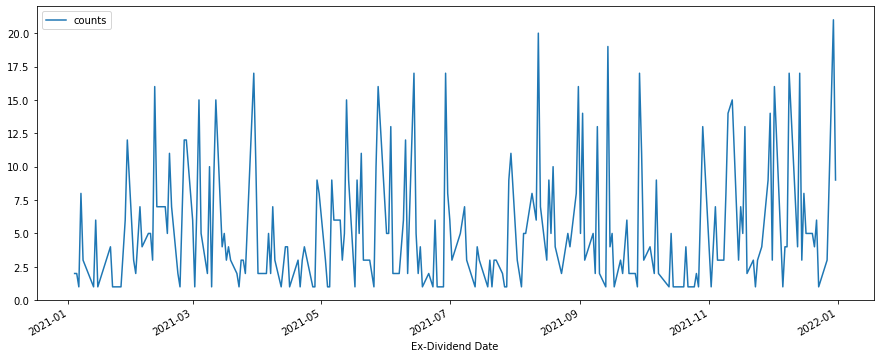

Days of at least 1 ex_dividend date in year = 222


In [101]:
#Count of ex-dividend stocks per day in 2021
exdd_ticker_count(pd.to_datetime(datetime.date(2021,1,1)),pd.to_datetime(datetime.date(2022,1,1)))

### Thus, for target pool of stocks, i see there are more than 220 days in a trading year of 240 days with at least 1 stock's ExDD happening. This is considering NASDAQ only and not other exchanges.

# Data Extraction and Feature Engineering for Target Pool

In [10]:
#Define function which extracts price data from yfinance and performs pre-processing to add columns of "nearest ex-dividend", 
#"relative ex-dividend date"

model_df_cols=['Date','ticker','Quarter','Rel_ExDD','Due_Dividend','Open','High','Low','Close','Volume']

def stock_matrix(ticker, start_date_year,start_date_month,start_date_day):
    stock_data=yf.Ticker(ticker)
    #delisted.append(ticker)
    data=stock_data.history(period='10y').reset_index()
    if len(data[data.Dividends!=0])>0:
        data['ticker']=[ticker]*len(data)
        start_date=pd.to_datetime(datetime.date(start_date_year,start_date_month,start_date_day))
    
        def nearest_exdd(row_date):
            reduced_df=data[(data.Date>=row_date-datetime.timedelta(days=366)) & (data.Date<row_date+datetime.timedelta(days=366)) & (data.Dividends!=0.0)].copy()
            delta_days=[abs(row_date-i) for i in reduced_df.Date]
            if len(delta_days)>0:
                nearest_index=delta_days.index(min(delta_days))
                return list(reduced_df.Date)[nearest_index]
            else:
                delta_days=[abs(row_date-i) for i in data[data.Dividends!=0.0].Date]
                if len(delta_days)>0:
                    nearest_index=delta_days.index(min(delta_days))
                    return list(data[data.Dividends!=0.0].Date)[nearest_index]
                else:
                    return data[data.Dividends!=0.0].Date[-1]
    
        data['Nearest_ExDD']=data.Date.apply(lambda x:nearest_exdd(x))
    
        #Quarter
        #Depending on the learning algorithm being used, have to switch between Q1-Q2-Q3-Q4 and 1-2-3-4
        #data['Quarter']=data.Date.apply(lambda x: 'Q1' if x.month<=3 else 'Q2' if x.month<=6 else 'Q3' if x.month<=9 else 'Q4')
        data['Quarter']=data.Date.apply(lambda x: 1 if x.month<=3 else 2 if x.month<=6 else 3 if x.month<=9 else 4)
    
        #Trading Day
        #For start date of 01 Jan 2014, apply count from 01 Jan 2013
        use_date=pd.to_datetime(datetime.date(start_date_year,start_date_month,start_date_day))-datetime.timedelta(days=366)
        zeros=[0 for i in range(data[data.Date>=use_date].index[0])]
        trading_days=([i for i in range(data[data.Date>=use_date].shape[0])])
        zeros.extend(trading_days)
        data['trading_day']=zeros
    
        #Due_Quarterly_Dividend
        data['Due_Dividend']=data.Nearest_ExDD.apply(lambda x:float(data.Dividends[data.Date==x]))
    
        #Trading Days relative to ExDD
        data['Nearest_ExDD_trading_day']=data.Nearest_ExDD.apply(lambda x:int(data.trading_day[data.Date==x]))
        data['Rel_ExDD']=data.trading_day-data.Nearest_ExDD_trading_day #this is built on trading days and not on absolute dates
       
        #for date>= start_date
        model_df=data[data.Date>=start_date][model_df_cols].reset_index(drop=True).copy()
        env_df=data[data.Date>=start_date].reset_index(drop=True).copy()
    
        return model_df,env_df
    else:
        return "error","error"

In [143]:
#Started at 1145 hrs; Expect 30 mins for 329 tickers
#Creating the dictionaries which will hold all the data from the market for the environment & agent
#trading_day_dict={} #the full trading_day_dict to identify row in stock matrix for a given market_state_vector
market_state_dict={} #the dictionary of ticker:market_state_vector
stock_matrix_dict={} #the dictionary of ticker:stock_Matrix
error_tickers2=[]
for ticker in tqdm_notebook(target_pool):
    m_df,e_df=stock_matrix(ticker,2014,1,1)
    if type(m_df)!=str:
        new_market_state_dict={ticker:m_df}
        new_stock_matrix_dict={ticker:e_df}
        #new_trading_dict={tuple(np.array(e_df[e_df['trading_day']==trading_day][list(m_df.columns)])[0]):trading_day for trading_day in e_df.trading_day}
        #trading_day_dict.update(new_trading_dict)
        market_state_dict.update(new_market_state_dict) #not necessary actually; can delete this and others related to it above
        stock_matrix_dict.update(new_stock_matrix_dict)
    else:
        error_tickers2.append(ticker)

In [144]:
#Checking if any tickers from target pool had data error
error_tickers2

[]

In [155]:
#make list of all trading dates since 1 Jan 2014
trading_dates=list(stock_matrix_dict.get('SLB').Date)

In [156]:
#Saving list of trading dates
pd.Series(trading_dates).to_excel(f"trading_dates_thesis_{str(datetime.date.today())}.xlsx", index=False)

In [157]:
#Since dictionary values cannot be changed, i will convert to list before normalising the length of all the dataframes 
#to include all stocks in target pool with 0 value for dates prior to their listing in NASDAQ

sm_list=[pd.concat([stock_matrix_dict.get(ticker)[stock_matrix_dict.get(ticker).Date==day] for ticker in target_pool],ignore_index=True) for day in trading_dates]

In [159]:
stock_matrix_dict.get('SLB').columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'ticker', 'Nearest_ExDD', 'Quarter', 'trading_day',
       'Due_Dividend', 'Nearest_ExDD_trading_day', 'Rel_ExDD'],
      dtype='object')

In [160]:
#inserting rows for missing stocks to make all vectors of the same shape
#for dataframe in sm_list:
def extend_df(dataframe):
    dataframe.reset_index(drop=True, inplace=True)
    this_date=dataframe.Date[0]
    temp_index=len(dataframe)
    if len(dataframe) < len(target_pool):
        missing=set(target_pool)-set(dataframe.ticker)
        for ticker in missing:
            temp_dict={'Date':this_date, 'Open':0, 'High':0, 'Low':0, 'Close':0, 'Volume':0, 'Dividends':0,
       'Stock Splits':0, 'ticker':ticker, 'Nearest_ExDD':0, 'Quarter':0, 'trading_day':0,
       'Due_Dividend':0, 'Nearest_ExDD_trading_day':0, 'Rel_ExDD':0}
            new_df=pd.DataFrame(temp_dict,index={temp_index}) #create dataframe with blank rows for the missing ticker symbols
            dataframe=dataframe.append(new_df,ignore_index=True).sort_values(by='ticker') #concatenate this new dataframe with the old dataframe     
            temp_index+=1
    return dataframe
    #dataframe.sort_values(by='ticker').reset_index(drop=True, inplace=True) #sort & save the dataframe in dictionary

In [161]:
#Create foundational dictionary STOCK MATRIX for target pool
stock_matrix_dict2={dataframe.Date[0]:extend_df(dataframe) for dataframe in sm_list}

In [162]:
#Check if any dataframe has length less than target_pool
for df in stock_matrix_dict2.values():
    if len(df)!=len(target_pool):
        print(df.Date[0],len(df))

In [8]:
#Get outstanding shares for target pool
outstanding_shares=dict()
for ticker in tqdm_notebook(target_pool):
    ticker1=yf.Ticker(ticker)
    try:
        outstanding_shares[ticker]=ticker1.info['sharesOutstanding']
    except:
        outstanding_shares[ticker]=999999999 #assigning a high number for stocks which do not have this data from yfinance

In [16]:
#I observe there are some values marked as None; i will fix this
for key in outstanding_shares.keys():
    if outstanding_shares.get(key) is None:
        outstanding_shares[key]=999999999

**Feature Engineering**

In [6]:
#Loading saved trading_dates for thesis
trading_dates=list(pd.read_excel("trading_dates_thesis_2022-07-13.xlsx").iloc[:][0])

In [7]:
#Loading saved target_pool for thesis
target_pool=list(pd.read_excel("target_pool_thesis_2022-07-12.xlsx").iloc[:][0])

In [56]:
#Define the function get_prev_qtr_dividend() used in next cell
#Previous Qtr Dividend

def get_prev_qtr_dividend(slb_df):
    chk=slb_df[slb_df.Rel_ExDD==0].reset_index()
    chk=chk.rename(columns={'index':'row_id'})
    list1=[chk.Dividends[0]]*(chk.row_id[0]-0)
    for idx in range(len(chk)-1):
        this_list=[chk.Dividends[idx]]*(chk.row_id[idx+1]-chk.row_id[idx])
        list1.extend(this_list)
    this_list=[list(chk.Dividends)[-1]]*(len(slb_df)-len(list1))
    list1.extend(this_list)
    return list1

In [66]:
def add_features(slb_df,outstanding_shares_count):
    
    #this block of code adds columns with previous day's data for each row
    shifting_cols_by_one_day=['p_High','p_Low','p_Close','p_Volume']
    shifting_cols_by_two_days=['p2_Close']
    slb_df['p_Open']=slb_df.Open #previous day's data
    slb_df['p_High']=slb_df.High #previous day's data
    slb_df['p_Low']=slb_df.Low #previous day's data
    slb_df['p_Close']=slb_df.Close #previous day's data
    slb_df['p2_Close']=slb_df.Close #Close price from 2 days prior
    slb_df['p_Volume']=slb_df.Volume #previous day's data
    slb_df[shifting_cols_by_one_day]=slb_df[shifting_cols_by_one_day].shift(periods=1)
    slb_df[shifting_cols_by_two_days]=slb_df[shifting_cols_by_two_days].shift(periods=2)
    
    #this block of code adds non-technical features
    slb_df['Dividend/p_Pc']=slb_df.Due_Dividend/slb_df.p_Close
    slb_df['Weekday']=slb_df.Date.apply(lambda x:x.weekday())/4 #scaled between 0 and 1
    slb_df['Month']=slb_df.Date.apply(lambda x:x.month)/12 #scaled between 0 and 1
    slb_df['Week']=slb_df.Date.apply(lambda x:x.week)/52 #scaled between 0 and 1
    slb_df['Current_Year']=slb_df.Date.apply(lambda x:x.year)
    slb_df['p_Open/p_Close']=slb_df.p_Open/slb_df.p_Close
    slb_df['p_Low/p_Close']=slb_df.p_Low/slb_df.p_Close
    slb_df['p_High/p_Close']=slb_df.p_High/slb_df.p_Close
    slb_df['Open/p_Close']=slb_df.Open/slb_df.p_Close
    slb_df['p2_Close/p_Close']=slb_df.p_Open/slb_df.p_Close
    slb_df['TTO']=slb_df.p_Volume/outstanding_shares_count
    slb_df['TTO_MA5']=talib.MA(slb_df.TTO, timeperiod=5, matype=0)
    slb_df['TTO_MA45']=talib.MA(slb_df.TTO, timeperiod=45, matype=0)
    slb_df['ATTO_5']=slb_df['TTO']-slb_df['TTO_MA5']
    slb_df['ATTO_45']=slb_df['TTO']-slb_df['TTO_MA45']
    slb_df['Beta_22']=talib.BETA(slb_df.p_High, slb_df.p_Low, timeperiod=22)
    slb_df['Beta_64']=talib.BETA(slb_df.p_High, slb_df.p_Low, timeperiod=64)
    
    #this block of code adds technical features
    slb_df['MACD_short']=talib.MACD(slb_df.p_Close, fastperiod=3, slowperiod=10, signalperiod=5)[0]
    slb_df['MACD_Signal_short']=talib.MACD(slb_df.p_Close, fastperiod=3, slowperiod=10, signalperiod=5)[1]
    slb_df['MACD_hist_short']=talib.MACD(slb_df.p_Close, fastperiod=3, slowperiod=10, signalperiod=5)[2]
    slb_df['MACD_long']=talib.MACD(slb_df.p_Close, fastperiod=12, slowperiod=26, signalperiod=9)[0]
    slb_df['MACD_Signal_long']=talib.MACD(slb_df.p_Close, fastperiod=12, slowperiod=26, signalperiod=9)[1]
    slb_df['MACD_hist_long']=talib.MACD(slb_df.p_Close, fastperiod=12, slowperiod=26, signalperiod=9)[2]

    slb_df['PPO_short']=talib.PPO(slb_df.p_Close, fastperiod=3, slowperiod=10, matype=1) #EMA is matype=1; help(talib.MA_Type)
    slb_df['PPO_long']=talib.PPO(slb_df.p_Close, fastperiod=12, slowperiod=26, matype=1) #EMA is matype=1; help(talib.MA_Type)

    slb_df['10_day_SMA']=talib.MA(slb_df.p_Close, timeperiod=10, matype=0)
    slb_df['12_day_EMA']=talib.MA(slb_df.p_Close, timeperiod=10, matype=1)
    slb_df['10_day_WMA']=talib.WMA(slb_df.p_Close, timeperiod=10)# or talib.MA(slb_df.p_Close, timeperiod=10, matype=2)
    slb_df['Momentum_long']=talib.MOM(slb_df.p_Close, timeperiod=10)
    slb_df['Momentum_short']=talib.MOM(slb_df.p_Close, timeperiod=5)

    slb_df["StochFast_K"]=talib.STOCHF(slb_df.p_High, slb_df.p_Low, slb_df.p_Close, fastk_period=5, fastd_period=3, fastd_matype=0)[0]
    slb_df["StochFast_D"]=talib.STOCHF(slb_df.p_High, slb_df.p_Low, slb_df.p_Close, fastk_period=5, fastd_period=3, fastd_matype=0)[1]
    slb_df["StochSlow_K"]=talib.STOCH(slb_df.p_High, slb_df.p_Low, slb_df.p_Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)[0]
    slb_df["StochSlow_D"]=talib.STOCH(slb_df.p_High, slb_df.p_Low, slb_df.p_Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)[1]

    slb_df["RSI"]=talib.RSI(slb_df.p_Close, timeperiod=14)
    slb_df["Williams_R"]=talib.WILLR(slb_df.p_High, slb_df.p_Low, slb_df.p_Close, timeperiod=14)
    slb_df["ADO"]=talib.ADOSC(slb_df.p_High, slb_df.p_Low, slb_df.p_Close, slb_df.p_Volume, fastperiod=3, slowperiod=10)
    slb_df["OBV"]=talib.OBV(slb_df.p_Close, slb_df.p_Volume)/1000000000 #measured in billions
    slb_df["CCI"]=talib.CCI(slb_df.p_High, slb_df.p_Low, slb_df.p_Close, timeperiod=14)
    slb_df['MA3']=talib.MA(slb_df.p_Close, timeperiod=3, matype=0)
    slb_df["Bias"]=(slb_df.p_Close-slb_df.MA3)/slb_df.MA3

In [77]:
#Adding features for target pool in stock_matrix_dict; superfast execution in 22 seconds only!!
error_tickers3=[]
for ticker in tqdm_notebook(target_pool):
    try:
        edit_df=stock_matrix_dict.get(ticker) 
        edit_df['Prev_Qtr_Dividend']=get_prev_qtr_dividend(edit_df)
        shift_periods=list(edit_df[edit_df.Rel_ExDD==0].index)[0]
        #Fix Due_Dividends
        edit_df['Due_Dividends']=edit_df['Prev_Qtr_Dividend'].shift(periods=-shift_periods)
        edit_df.Due_Dividends.fillna(list(edit_df[edit_df.Rel_ExDD==0].Dividends)[-1],inplace=True)

        #Add feature of inverse Log Dividend Change (LogDC)
        edit_df['LogDC']=1/np.log(edit_df.Due_Dividends-edit_df.Prev_Qtr_Dividend)
    
        #Add all planned features
        outstd_shares=outstanding_shares.get(ticker)
        add_features(edit_df,outstd_shares)
    
        #update stock_matrix_dict
        stock_matrix_dict[ticker] = edit_df
    except:
        error_tickers3.append(ticker)

In [78]:
#Checking if any tickers couldn't be processed
error_tickers3

[]

In [79]:
#Saving the stock matrix with features dictionary as a pickle file
#with open('stock_matrix_features_dict.pickle', 'wb') as handle:
#    pickle.dump(stock_matrix_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

***References for ta-lib:***
- https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
- help(talib.MA_Type) ... this one is excellent
- talib.get_functions()
- https://www.fmlabs.com/reference/default.htm?url=MACD.htm

Yesterday MACD (54,26) and (24,12) with Signal for both based on 9 days
Yesterday PPO (54,26) and (24,12) with Signal for both based on 9 days
Yesterday MACD/Signal
Yesterday PPO/Signal
Yesterday Ph/MACD
Yesterday Pc/MACD
Yesterday Slope MACD
Yesterday Slope PPO
Yesterday Po/Pc
Yesterday Pl/Pc
Yesterday Ph/Pc
Today Po/Yesterday Pc
Day-before-Yesterday Pc/Yesterday Pc

MACD & Signal
PPO & Signal
10 day MA
Weighted 10 day MA
EMA 12 day
Momentum
Fast K
Fast D
Slow K
Slow D
RSI
William's R
Accumulation Distribution Oscillator
Commodity Channel Index
On Balance Volume
Bias

Log of Dividend Change (LogDC) or ratio of Current Due_Dividend to Last Due_Dividend 
Beta_22 and Beta_64
Yesterday Traded Volume/Total Outstanding Shares
Yesterday Traded Volume/Total Outstanding Shares - N day avg of (Traded Volume/Total Outstanding Shares); N = 5 & 45

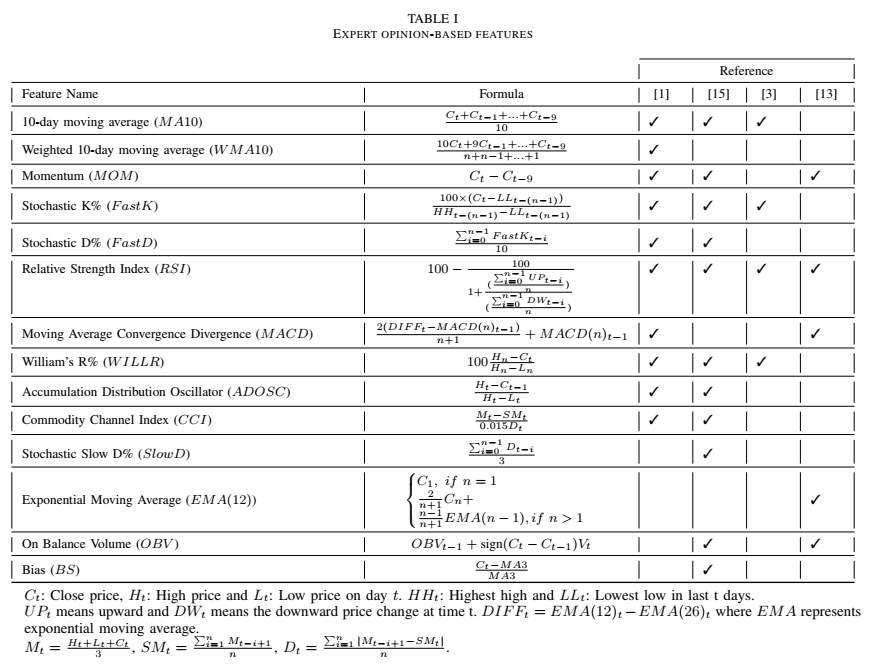

In [102]:
stock_matrix_dict.get('SLB').head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Nearest_ExDD,Quarter,trading_day,Due_Dividend,Nearest_ExDD_trading_day,Rel_ExDD,Prev_Qtr_Dividend,Due_Dividends,LogDC,p_Open,p_High,p_Low,p_Close,p2_Close,p_Volume,Dividend/p_Pc,Weekday,Month,Week,Current_Year,p_Open/p_Close,p_Low/p_Close,p_High/p_Close,Open/p_Close,p2_Close/p_Close,TTO,TTO_MA5,TTO_MA45,ATTO_5,ATTO_45,Beta_22,Beta_64,MACD_short,MACD_Signal_short,MACD_hist_short,MACD_long,MACD_Signal_long,MACD_hist_long,PPO_short,PPO_long,10_day_SMA,12_day_EMA,10_day_WMA,Momentum_long,Momentum_short,StochFast_K,StochFast_D,StochSlow_K,StochSlow_D,RSI,Williams_R,ADO,OBV,CCI,MA3,Bias
0,2014-01-02,70.225471,70.727754,69.542678,69.707489,4958100,0.0,0,SLB,2013-12-02,1,253,0.313,232,21,0.4,0.4,-0.0,70.225471,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.083333,0.019231,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,69.801653,70.123425,69.228734,69.338608,4212000,0.0,0,SLB,2013-12-02,1,254,0.313,232,22,0.4,0.4,-0.0,69.801653,70.727754,69.542678,69.707489,NaN,4958100.0,0.004490,1.00,0.083333,0.019231,2014,1.001351,0.997636,1.014636,1.001351,1.001351,0.003535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004958,NaN,NaN,NaN
2,2014-01-06,69.754579,69.785973,68.514572,69.079636,6370100,0.0,0,SLB,2013-12-02,1,255,0.313,232,23,0.4,0.4,-0.0,69.754579,70.123425,69.228734,69.338608,69.707489,4212000.0,0.004514,0.00,0.083333,0.038462,2014,1.005999,0.998415,1.011319,1.005999,1.005999,0.003003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000746,NaN,NaN,NaN
3,2014-01-07,69.103169,69.424941,68.098598,68.679367,6423800,0.0,0,SLB,2013-12-02,1,256,0.313,232,24,0.4,0.4,-0.0,69.103169,69.785973,68.514572,69.079636,69.338608,6370100.0,0.004531,0.25,0.083333,0.038462,2014,1.000341,0.991820,1.010225,1.000341,1.000341,0.004542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005624,NaN,69.375244,-0.004261
4,2014-01-08,68.561633,68.797081,67.792510,68.263405,8527100,0.0,0,SLB,2013-12-02,1,257,0.313,232,25,0.4,0.4,-0.0,68.561633,69.424941,68.098598,68.679367,69.079636,6423800.0,0.004557,0.50,0.083333,0.038462,2014,0.998286,0.991544,1.010856,0.998286,0.998286,0.004580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012048,NaN,69.032537,-0.005116


**DATA PROCESSING AND LABELLED DATA FOR CLASSIFICATION/REGRESSION**

In [105]:
#Create dataframe including all data of target pool from stock_matrix_dict
pool_data=pd.concat(list(stock_matrix_dict.values()), ignore_index=True)

In [107]:
#Taking only data within 4 days of ex-div-date
new_df=pool_data[(pool_data.Rel_ExDD>=-4) & (pool_data.Rel_ExDD<=0)]

In [112]:
new_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Nearest_ExDD,Quarter,trading_day,Due_Dividend,Nearest_ExDD_trading_day,Rel_ExDD,Prev_Qtr_Dividend,Due_Dividends,LogDC,p_Open,p_High,p_Low,p_Close,p2_Close,p_Volume,Dividend/p_Pc,Weekday,Month,Week,Current_Year,p_Open/p_Close,p_Low/p_Close,p_High/p_Close,Open/p_Close,p2_Close/p_Close,TTO,TTO_MA5,TTO_MA45,ATTO_5,ATTO_45,Beta_22,Beta_64,MACD_short,MACD_Signal_short,MACD_hist_short,MACD_long,MACD_Signal_long,MACD_hist_long,PPO_short,PPO_long,10_day_SMA,12_day_EMA,10_day_WMA,Momentum_long,Momentum_short,StochFast_K,StochFast_D,StochSlow_K,StochSlow_D,RSI,Williams_R,ADO,OBV,CCI,MA3,Bias
0,2014-01-02,17.003218,17.095252,16.803812,16.872837,44377000.0,0.17,0.0,CSCO,2014-01-02,1,253,0.17,253,0,0.17,0.17,-0.0,17.003218,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.083333,0.019231,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2014-03-26,17.210292,17.402029,17.118258,17.118258,67098900.0,0.00,0.0,CSCO,2014-04-01,1,310,0.19,314,-4,0.17,0.17,-0.0,17.210292,17.148934,16.604401,17.133595,16.543043,53374300.0,0.011089,0.50,0.250000,0.250000,2014,1.004476,0.969114,1.000895,1.004476,1.004476,0.012889,0.012130,0.010619,0.000759,0.002271,0.565181,NaN,0.157032,0.036726,0.120306,-0.059404,-0.108819,0.049415,0.940209,-0.351580,16.630476,16.701788,16.682349,0.559870,0.544535,97.752767,58.966315,58.966315,56.603613,60.216444,-1.834895,-2.729046e+07,-0.271846,223.422129,16.757790,0.022426
58,2014-03-27,16.972539,17.171946,16.826820,16.888176,52152300.0,0.00,0.0,CSCO,2014-04-01,1,311,0.19,314,-3,0.17,0.17,-0.0,16.972539,17.402029,17.118258,17.118258,17.133595,67098900.0,0.011099,0.75,0.250000,0.250000,2014,0.991488,1.000000,1.016577,0.991488,0.991488,0.016204,0.013793,0.010799,0.002411,0.005404,0.740750,NaN,0.211029,0.094827,0.116202,-0.021422,-0.091339,0.069917,1.257809,-0.125163,16.668824,16.777509,16.771037,0.383476,0.529198,69.672225,67.330874,67.330874,59.416679,59.732292,-26.056247,-3.952134e+07,-0.338945,271.512572,16.931632,0.011022
59,2014-03-28,16.941856,17.286983,16.911178,17.125923,49289400.0,0.00,0.0,CSCO,2014-04-01,1,312,0.19,314,-2,0.17,0.17,-0.0,16.941856,17.171946,16.826820,16.888176,17.118258,52152300.0,0.011250,1.00,0.250000,0.250000,2014,1.003179,0.996367,1.016803,1.003179,1.003179,0.012594,0.014624,0.010915,-0.002029,0.001680,0.771229,NaN,0.140727,0.110127,0.030600,-0.009774,-0.075026,0.065252,0.837777,-0.056116,16.707171,16.797631,16.810919,0.383474,0.145727,45.082466,70.835820,70.835820,65.711003,52.865342,-47.182651,-5.162588e+07,-0.391097,115.009350,17.046676,-0.009298
60,2014-03-31,17.248638,17.363680,17.179613,17.194952,32887800.0,0.00,0.0,CSCO,2014-04-01,1,313,0.19,314,-1,0.17,0.17,-0.0,17.248638,17.286983,16.911178,17.125923,16.888176,49289400.0,0.011094,0.00,0.250000,0.269231,2014,1.007165,0.987461,1.009404,1.007165,1.007165,0.011903,0.012301,0.010980,-0.000398,0.000922,0.755323,NaN,0.174820,0.131691,0.043129,0.018429,-0.056335,0.074764,1.037057,0.111360,16.782332,16.857320,16.887056,0.751606,0.529192,70.491483,61.748725,61.748725,66.638473,58.211369,-25.352378,-4.964407e+07,-0.341808,133.066291,17.044119,0.004800


In [118]:
#Checking if any prices are negative
new_df[new_df.Close<0].shape

(0, 65)

In [153]:
#new_df.drop(new_df[new_df.Close<0].index,inplace=True) #Dropping negative price rows

In [120]:
#Checking if any prices are zero
new_df[new_df.Open==0].shape

(0, 65)

In [136]:
new_df.shape

(52213, 65)

In [125]:
#Checking columns with null values
for col in new_df.columns:
    null_count=new_df[new_df[col].isna()].shape[0]
    if null_count>0:
        print(col,'\t',round(null_count/new_df.shape[0]*100,2),'% of data is null')

LogDC 	 4.35 % of data is null
p_High 	 0.02 % of data is null
p_Low 	 0.02 % of data is null
p_Close 	 0.02 % of data is null
p2_Close 	 0.04 % of data is null
p_Volume 	 0.02 % of data is null
Dividend/p_Pc 	 0.02 % of data is null
p_Open/p_Close 	 0.02 % of data is null
p_Low/p_Close 	 0.02 % of data is null
p_High/p_Close 	 0.02 % of data is null
Open/p_Close 	 0.02 % of data is null
p2_Close/p_Close 	 0.02 % of data is null
TTO 	 0.02 % of data is null
TTO_MA5 	 0.09 % of data is null
TTO_MA45 	 2.09 % of data is null
ATTO_5 	 0.09 % of data is null
ATTO_45 	 2.09 % of data is null
Beta_22 	 0.65 % of data is null
Beta_64 	 2.98 % of data is null
MACD_short 	 0.28 % of data is null
MACD_Signal_short 	 0.28 % of data is null
MACD_hist_short 	 0.28 % of data is null
MACD_long 	 1.33 % of data is null
MACD_Signal_long 	 1.33 % of data is null
MACD_hist_long 	 1.33 % of data is null
PPO_short 	 0.2 % of data is null
PPO_long 	 0.84 % of data is null
10_day_SMA 	 0.2 % of data is null


**I observe that a large number of LogDC values are null followed by TTO_MA45, ATTO_45, Beta_64. I will investigate if these missing values are at the beginning of the timeline or spread throughout the timeline. If its only at the beginning, i will drop the null rows; if its throughout the data timeline, then i will drop the column**

In [140]:
#Checking null values of LogDC
for i in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]:
    print(i,'\t',len(new_df[(new_df.Current_Year==i) & (new_df.LogDC.isna())]))
          #.to_frame('Count of Stocks').reset_index().sort_values(by=['index']).rename(columns={"index": "Label"}))
          #new_df.LogDC.value_counts()

2014 	 200
2015 	 311
2016 	 302
2017 	 208
2018 	 262
2019 	 291
2020 	 315
2021 	 252


In [142]:
#Checking null values of TTO_MA45
for i in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]:
    print(i,'\t',len(new_df[(new_df.Current_Year==i) & (new_df.TTO_MA45.isna())]))

2014 	 1070
2015 	 15
2016 	 0
2017 	 0
2018 	 0
2019 	 6
2020 	 0
2021 	 0


In [143]:
#Checking null values of ATTO_45
for i in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]:
    print(i,'\t',len(new_df[(new_df.Current_Year==i) & (new_df.ATTO_45.isna())]))

2014 	 1070
2015 	 15
2016 	 0
2017 	 0
2018 	 0
2019 	 6
2020 	 0
2021 	 0


In [144]:
#Checking null values of Beta_64
for i in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]:
    print(i,'\t',len(new_df[(new_df.Current_Year==i) & (new_df.Beta_64.isna())]))

2014 	 1503
2015 	 20
2016 	 5
2017 	 0
2018 	 10
2019 	 15
2020 	 5
2021 	 0


Based on the above observations, i will drop the LogDC column. After that, i will drop all null rows in dataframe.

In [145]:
#Dropping LogDC column
new_df=new_df.drop(columns=['LogDC'])

In [146]:
#Dropping null value rows for TTO_MA45
new_df.drop(new_df[new_df.TTO_MA45.isna()].index,inplace=True)

In [148]:
#Dropping null value rows for Beta_64
new_df.drop(new_df[new_df.Beta_64.isna()].index,inplace=True)

In [149]:
#Checking columns with null values
for col in new_df.columns:
    null_count=new_df[new_df[col].isna()].shape[0]
    if null_count>0:
        print(col,'\t',round(null_count/new_df.shape[0]*100,2),'% of data is null')

In [150]:
new_df.shape

(50655, 64)

In [157]:
#Checking if consistent number of stocks are available 4 days prior data to exDD from 2014 to 2021
new_df[(new_df.Rel_ExDD==-4)].Current_Year.value_counts()

2019    1278
2018    1254
2017    1231
2016    1229
2015    1215
2021    1212
2020    1192
2014     884
2022     627
Name: Current_Year, dtype: int64

In [158]:
#Only retaining rel_exdd>=-3 in dataset
new_df.drop(new_df[new_df.Rel_ExDD==-4].index,inplace=True)

In [161]:
#Creating list of unique dates in dataset
dates=list(new_df.Date.unique())
dates.sort()

In [162]:
#Sorting dataframe by Date
new_df.sort_values(by=['Date'],inplace=True)
#Reset index
new_df.reset_index(inplace=True, drop=True)

In [163]:
new_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Nearest_ExDD,Quarter,trading_day,Due_Dividend,Nearest_ExDD_trading_day,Rel_ExDD,Prev_Qtr_Dividend,Due_Dividends,p_Open,p_High,p_Low,p_Close,p2_Close,p_Volume,Dividend/p_Pc,Weekday,Month,Week,Current_Year,p_Open/p_Close,p_Low/p_Close,p_High/p_Close,Open/p_Close,p2_Close/p_Close,TTO,TTO_MA5,TTO_MA45,ATTO_5,ATTO_45,Beta_22,Beta_64,MACD_short,MACD_Signal_short,MACD_hist_short,MACD_long,MACD_Signal_long,MACD_hist_long,PPO_short,PPO_long,10_day_SMA,12_day_EMA,10_day_WMA,Momentum_long,Momentum_short,StochFast_K,StochFast_D,StochSlow_K,StochSlow_D,RSI,Williams_R,ADO,OBV,CCI,MA3,Bias
0,2014-04-07,35.684656,35.803325,35.161113,35.230919,1139389.0,0.0,0.0,DRI,2014-04-08,2,318,0.491645,319,-1,0.491645,0.491645,35.684656,36.647967,35.726533,35.768417,36.277996,1036469.0,0.013745,0.0,0.333333,0.288462,2014,0.997658,0.998829,1.024590,0.997658,0.997658,0.008309,0.009719,0.013425,-0.001410,-0.005116,0.326724,0.557124,0.304838,0.374044,-0.069205,0.339386,0.212689,0.126697,0.855098,0.963039,35.639281,35.649518,35.793297,0.404873,0.432785,32.619999,73.245748,73.245748,81.591296,56.287028,-33.689956,5.560989e+05,0.015543,99.952265,36.136061,-0.010174
1,2014-04-07,41.044773,41.101995,39.442548,39.589691,2924400.0,0.0,0.0,LNC,2014-04-08,2,318,0.160000,319,-1,0.160000,0.160000,41.044773,42.491681,41.126520,41.183743,42.140175,1826600.0,0.003885,0.0,0.333333,0.288462,2014,0.996626,0.998611,1.031759,0.996626,0.996626,0.010623,0.009405,0.012109,0.001218,-0.001486,0.583707,0.787989,-0.087994,-0.034603,-0.053391,0.059669,0.124287,-0.064618,-0.211205,0.144911,41.650516,41.663052,41.583112,-1.324299,0.384212,5.000046,54.283452,54.283452,59.010531,46.688372,-76.923519,-1.243261e+06,0.011531,-38.907883,41.826813,-0.015375
2,2014-04-07,38.520742,39.157138,38.438384,38.820221,5409100.0,0.0,0.0,GIS,2014-04-08,2,318,0.410000,319,-1,0.380000,0.410000,38.520742,38.947511,38.341061,38.371010,39.104740,4452200.0,0.010685,0.0,0.333333,0.288462,2014,1.003902,0.999219,1.015024,1.003902,1.003902,0.007456,0.005419,0.005307,0.002036,0.002149,0.830942,0.727057,0.117390,0.217968,-0.100578,0.351729,0.342061,0.009668,0.304846,0.922907,38.481816,38.508104,38.604603,0.164722,-0.037437,3.571493,52.899451,52.899451,69.372674,54.190669,-54.545079,-5.129114e+05,0.016757,43.706791,38.707923,-0.008704
3,2014-04-07,30.249642,30.427579,29.351859,29.359945,5006700.0,0.0,0.0,NTAP,2014-04-08,2,318,0.150000,319,-1,0.150000,0.150000,30.249642,30.977571,30.184934,30.354784,30.346691,8188800.0,0.004942,0.0,0.333333,0.288462,2014,0.996536,0.994405,1.020517,0.996536,0.996536,0.037022,0.019391,0.025916,0.017631,0.011106,0.650173,0.584891,0.188372,0.052853,0.135519,-0.511663,-0.696722,0.185059,0.625622,-1.671483,29.886478,30.109632,30.030668,-0.218370,1.091900,62.801979,80.498352,80.498352,78.352813,46.482935,-34.070826,-3.732537e+06,-0.040336,111.111761,30.381744,-0.000887
4,2014-04-07,46.233769,46.504105,45.852841,46.221481,4565818.0,0.0,0.0,YUM,2014-04-09,2,318,0.265996,320,-2,0.265996,0.265996,46.233769,47.229102,46.147753,46.350506,46.964901,3627867.0,0.005739,0.0,0.333333,0.288462,2014,0.997481,0.995626,1.018955,0.997481,0.997481,0.012722,0.014866,0.015639,-0.002144,-0.002917,0.693018,0.879943,0.251127,0.278445,-0.027318,0.261642,0.222100,0.039541,0.541506,0.570329,46.099829,46.375653,46.386252,0.104446,0.761852,27.352857,60.200523,60.200523,78.356434,52.675676,-43.485799,-9.161352e+05,-0.000281,54.921613,46.897320,-0.011660


In [164]:
new_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Quarter,trading_day,Due_Dividend,Nearest_ExDD_trading_day,Rel_ExDD,Prev_Qtr_Dividend,Due_Dividends,p_Open,p_High,p_Low,p_Close,p2_Close,p_Volume,Dividend/p_Pc,Weekday,Month,Week,Current_Year,p_Open/p_Close,p_Low/p_Close,p_High/p_Close,Open/p_Close,p2_Close/p_Close,TTO,TTO_MA5,TTO_MA45,ATTO_5,ATTO_45,Beta_22,Beta_64,MACD_short,MACD_Signal_short,MACD_hist_short,MACD_long,MACD_Signal_long,MACD_hist_long,PPO_short,PPO_long,10_day_SMA,12_day_EMA,10_day_WMA,Momentum_long,Momentum_short,StochFast_K,StochFast_D,StochSlow_K,StochSlow_D,RSI,Williams_R,ADO,OBV,CCI,MA3,Bias
count,40533.000000,40533.000000,40533.000000,40533.000000,4.053300e+04,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,4.053300e+04,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,4.053300e+04,40533.000000,40533.000000,40533.000000,40533.000000,4.053300e+04,4.053300e+04,40533.000000,40533.000000,40533.000000,40533.000000
mean,75.390755,76.170278,74.579445,75.386851,4.973546e+06,0.143387,0.000206,2.501098,1339.334740,0.573331,1340.834036,-1.499297,0.564981,0.576413,75.390755,76.129745,74.545096,75.355107,75.317944,4.934116e+06,0.009956,0.487856,0.558074,0.525883,2017.897886,1.000499,0.989240,1.010645,1.000499,1.000499,0.007797,0.007955,0.007768,-0.000158,0.000029,0.751132,0.759187,0.094371,0.086288,0.008083,0.186557,0.190967,-0.004411,0.090315,0.199854,75.215944,75.225376,75.258157,0.256378,0.149511,5.363277e+01,53.725592,53.725592,53.821568,52.501263,-4.466981e+01,3.962161e+05,0.158832,12.466709,75.316500,0.000243
std,79.071590,80.245917,77.938778,79.127966,7.899672e+06,0.642593,0.017478,1.108306,600.740284,1.185380,600.740182,1.117992,1.181082,1.179708,79.071590,79.966277,77.762117,79.020442,78.665210,7.818467e+06,0.058180,0.343626,0.282226,0.285059,2.397923,0.011702,0.011338,0.013910,0.011702,0.011702,0.007888,0.007267,0.006062,0.004443,0.005381,0.267234,0.205140,2.640508,2.162678,0.949547,2.594879,2.284029,0.778141,1.980399,2.176879,78.481435,78.550660,78.517959,8.035044,6.088150,3.024279e+01,25.286295,25.286295,23.371417,12.332682,3.033664e+01,5.902644e+06,0.308621,108.390522,78.682929,0.014897
min,2.505278,2.680000,2.029243,2.038425,2.882300e+04,0.000000,0.000000,1.000000,66.000000,0.010000,69.000000,-3.000000,0.010000,0.010000,2.505278,2.702000,2.029243,2.038425,2.038425,0.000000e+00,0.000224,0.000000,0.083333,0.019231,2014.000000,0.597622,0.708099,1.000000,0.597622,0.597622,0.000000,0.000047,0.000062,-0.122504,-0.037794,-1.136482,-0.738499,-57.393951,-50.452045,-33.722372,-76.253645,-69.358568,-19.823383,-50.751936,-30.229125,2.706808,2.714033,2.701825,-214.169312,-141.346619,-6.777661e-13,0.401640,0.401640,1.745740,9.595888,-1.000000e+02,-8.524343e+07,-2.673754,-438.294737,2.479166,-0.658811
25%,33.226858,33.556572,32.866148,33.186375,1.435512e+06,0.000000,0.000000,2.000000,817.000000,0.258000,819.000000,-2.000000,0.250000,0.260000,33.226858,33.545690,32.854547,33.192638,33.199051,1.420400e+06,0.005413,0.250000,0.333333,0.269231,2016.000000,0.997116,0.985935,1.003186,0.997116,0.997116,0.003865,0.004161,0.004430,-0.001229,-0.001620,0.605125,0.655147,-0.355672,-0.319918,-0.171551,-0.352034,-0.306462,-0.160154,-0.711133,-0.739144,33.298264,33.296926,33.227537,-1.211208,-0.852890,2.670452e+01,32.459322,32.459322,34.606471,43.826648,-7.165459e+01,-8.736608e+05,0.024604,-71.810362,33.213415,-0.005557
50%,55.749095,56.296368,55.153526,55.722591,2.757800e+06,0.000000,0.000000,2.000000,1336.000000,0.444000,1337.000000,-1.000000,0.440000,0.448473,55.7490

In [196]:
#I observe a major outlier of Dividend/p_Pc above which is at 571%; i will find & drop this outlier
new_df[(new_df['Dividend/p_Pc']>=1)]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Nearest_ExDD,Quarter,trading_day,Due_Dividend,Nearest_ExDD_trading_day,Rel_ExDD,Prev_Qtr_Dividend,Due_Dividends,p_Open,p_High,p_Low,p_Close,p2_Close,p_Volume,Dividend/p_Pc,Weekday,Month,Week,Current_Year,p_Open/p_Close,p_Low/p_Close,p_High/p_Close,Open/p_Close,p2_Close/p_Close,TTO,TTO_MA5,TTO_MA45,ATTO_5,ATTO_45,Beta_22,Beta_64,MACD_short,MACD_Signal_short,MACD_hist_short,MACD_long,MACD_Signal_long,MACD_hist_long,PPO_short,PPO_long,10_day_SMA,12_day_EMA,10_day_WMA,Momentum_long,Momentum_short,StochFast_K,StochFast_D,StochSlow_K,StochSlow_D,RSI,Williams_R,ADO,OBV,CCI,MA3,Bias
20771,2018-07-05,18.207852,18.314218,18.172397,18.290581,5845800.0,0.00,0.0,KDP,2018-07-10,3,1387,103.75,1390,-3,0.58,103.75,18.207852,18.263984,18.111821,18.203415,18.271376,2394800.0,5.699480,0.75,0.583333,0.519231,2018,1.000244,0.994968,1.003327,1.000244,1.000244,0.001689,0.008375,0.001778,-0.006686,-0.000089,0.498381,0.668376,0.143194,0.064871,0.078324,0.084473,0.063629,0.020844,0.795622,0.472027,17.978868,17.997776,17.996622,0.211250,0.437277,89.248906,90.652015,90.652015,65.466988,63.044612,-16.824340,9.224414e+06,0.229116,128.302872,18.165992,0.002060
20795,2018-07-06,18.311259,18.371829,18.102958,18.159096,21284300.0,0.00,0.0,KDP,2018-07-10,3,1388,103.75,1390,-2,0.58,103.75,18.311259,18.314218,18.172397,18.290581,18.203415,5845800.0,5.672319,1.00,0.583333,0.519231,2018,1.001131,0.993539,1.001292,1.001131,1.001131,0.004123,0.008154,0.001859,-0.004031,0.002264,0.500146,0.670259,0.164762,0.098168,0.066595,0.102967,0.071497,0.031470,0.912760,0.574428,18.005607,18.051013,18.053297,0.267395,0.651489,96.893141,94.907393,94.907393,84.632408,65.550585,-5.670609,1.010818e+07,0.234962,135.781100,18.255124,0.001942
20803,2018-07-09,18.224100,18.284669,18.086710,18.268419,5536500.0,0.00,0.0,KDP,2018-07-10,3,1389,103.75,1390,-1,0.58,103.75,18.224100,18.371829,18.102958,18.159096,18.290581,21284300.0,5.713390,0.00,0.583333,0.538462,2018,1.003580,0.996909,1.011715,1.003580,1.003580,0.015011,0.009978,0.002176,0.005032,0.012835,0.494001,0.658483,0.116771,0.104369,0.012402,0.105793,0.078356,0.027437,0.646192,0.589628,18.016982,18.070664,18.081204,0.113749,0.431372,68.763408,84.968485,84.968485,90.175964,59.046214,-25.992901,5.606480e+06,0.213677,94.741118,18.217697,-0.003217
20812,2018-07-10,18.809768,20.543937,18.773066,20.360428,23632300.0,103.75,0.0,KDP,2018-07-10,3,1390,103.75,1390,0,103.75,103.75,18.809768,18.284669,18.086710,18.268419,18.159096,5536500.0,5.679200,0.25,0.583333,0.538462,2018,1.029633,0.990053,1.000889,1.029633,1.029633,0.003905,0.005776,0.002241,-0.001872,0.001664,0.487507,0.650962,0.121308,0.110015,0.011292,0.115524,0.085790,0.029734,0.669963,0.642992,18.036039,18.106620,18.126920,0.190575,0.245234,76.973978,80.876842,80.876842,86.917573,62.387990,-12.635149,4.727607e+06,0.219214,82.099630,18.239365,0.001593


In [197]:
#Dropping this outlier and resetting index
new_df=new_df[(new_df['Dividend/p_Pc']<1)]
#Reset index
new_df.reset_index(inplace=True, drop=True)

**LABELLED DATASET FOR CLASSIFICATION**

In [158]:
#Create code for strategy of buying on n-3, n-2 or n-1
transaction_cost=0.001 #0.1% of buy price
stop_loss_limit=0.96 
upside_limit=1+0.004+0.007*0
exdd_sell_trigger=1.001+0.005*0
def strategy3(df,date,stop_loss,upside_sell,exdd_sell):
    account=df[(df.Date==date) & (df.Rel_ExDD==-3)].copy()
    current_day_month=pd.to_datetime(date).month
    if len(account)>0:
        #account['Portfolio']=start_amount
        account['Buy_Price']=account.Close*(1+transaction_cost)
        account['Qty']=(1/(len(account)))/account.Buy_Price
        account['n-1_Low']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+2])].Low.reset_index().iloc[0][1] for ticker in account.ticker]
        account['n-1_High']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+2])].High.reset_index().iloc[0][1] for ticker in account.ticker]
        account['n-2_Low']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+1])].Low.reset_index().iloc[0][1] for ticker in account.ticker]
        account['n-2_High']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+1])].High.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_Open']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+3])].Open.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_Low']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+3])].Low.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_High']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+3])].High.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_Close']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+3])].Close.reset_index().iloc[0][1] for ticker in account.ticker]
        account['Trade P/L']=[
        (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-2_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (upside_sell-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-2_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-1_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (upside_sell-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-1_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (exdd_sell-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Close.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1]
        for ticker in account.ticker
        ]
        account['sell_trigger']=[
        2 if account[account.ticker==ticker]['n-2_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else 1 if account[account.ticker==ticker]['n-2_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else 2 if account[account.ticker==ticker]['n-1_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else 1 if account[account.ticker==ticker]['n-1_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else 3 if account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else 4 if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else 5 if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else 6
        for ticker in account.ticker
        ]
        account['Trade Max_P/L']=[
        (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-2_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker]['n-2_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-2_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-1_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker]['n-1_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-1_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Close.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1]
        for ticker in account.ticker
        ]
        return account, current_day_month, False
    else:
        return account, current_day_month, True


def strategy2(df,date,stop_loss,upside_sell,exdd_sell):
    account=df[(df.Date==date) & (df.Rel_ExDD==-2)].copy()
    current_day_month=pd.to_datetime(date).month
    if len(account)>0:
        #account['Portfolio']=start_amount
        account['Buy_Price']=account.Close*(1+transaction_cost)
        account['Qty']=(1/(len(account)))/account.Buy_Price
        account['n-2_Low']=0
        account['n-2_High']=0
        account['n-1_Low']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+1])].Low.reset_index().iloc[0][1] for ticker in account.ticker]
        account['n-1_High']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+1])].High.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_Open']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+2])].Open.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_Low']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+2])].Low.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_High']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+2])].High.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_Close']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+2])].Close.reset_index().iloc[0][1] for ticker in account.ticker]
        account['Trade P/L']=[
        (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-1_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (upside_sell-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-1_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (exdd_sell-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Close.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1]
        for ticker in account.ticker
        ]
        account['sell_trigger']=[
        2 if account[account.ticker==ticker]['n-1_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else 1 if account[account.ticker==ticker]['n-1_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else 3 if account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else 4 if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else 5 if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else 6
        for ticker in account.ticker
        ]
        account['Trade Max_P/L']=[
        (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-1_Low'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker]['n-1_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker]['n-1_High'].reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>upside_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Close.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1]
        for ticker in account.ticker
        ]
        return account, current_day_month, False
    else:
        return account, current_day_month, True
    
def strategy1(df,date,stop_loss,upside_sell,exdd_sell):
    account=df[(df.Date==date) & (df.Rel_ExDD==-1)].copy()
    current_day_month=pd.to_datetime(date).month
    if len(account)>0:
        #account['Portfolio']=start_amount
        account['Buy_Price']=account.Close*(1+transaction_cost)
        account['Qty']=(1/(len(account)))/account.Buy_Price
        account['n-2_Low']=0
        account['n-2_High']=0
        account['n-1_Low']=0
        account['n-1_High']=0
        account['ExDD_Open']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+1])].Open.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_Low']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+1])].Low.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_High']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+1])].High.reset_index().iloc[0][1] for ticker in account.ticker]
        account['ExDD_Close']=[df[(df.ticker==ticker) & (df.Date==dates[dates.index(account[account.ticker==ticker].Date.reset_index().iloc[0][1])+1])].Close.reset_index().iloc[0][1] for ticker in account.ticker]
        account['Trade P/L']=[
        (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (exdd_sell-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Close.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1]
        for ticker in account.ticker
        ]
        account['sell_trigger']=[
        3 if account[account.ticker==ticker].ExDD_Open.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else 4 if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else 5 if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else 6
        for ticker in account.ticker
        ]
        account['Trade Max_P/L']=[
        (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (stop_loss-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_Low.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]<stop_loss
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + (account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]-1)*account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1] if account[account.ticker==ticker].ExDD_High.reset_index().iloc[0][1]/account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1]>exdd_sell
        else (account[account.ticker==ticker].Due_Dividend.reset_index().iloc[0][1] + account[account.ticker==ticker].ExDD_Close.reset_index().iloc[0][1]-account[account.ticker==ticker].Buy_Price.reset_index().iloc[0][1])*account[account.ticker==ticker].Qty.reset_index().iloc[0][1]
        for ticker in account.ticker
        ]
        
        return account, current_day_month, False
    else:
        return account, current_day_month, True
#Considering i am capturing dividend everyday, after the first month, i will get paid dividend everyday as well. 
#Hence, the payment delay is not programmed here as it normalizes out after the first month.

In [159]:
#Creating function to execute strategy
def execute_strategy(strategy,stop_loss,upside_sell,exdd_sell,monthly_expense,tax_rate,df,use_dates):
    account1_1,prev_day_month,null_day=strategy(df,use_dates[0],stop_loss,upside_sell,exdd_sell) #Creating dataframe for first date in record
    #new_portfolio=account1_1['Trade P/L'].sum()+account1_1.Portfolio.mean() #updating portfolio value based on gain/loss/dividend
    #month_start_portfolio=initial_capital
    
    if strategy==strategy1:
        last_day=-2
    elif strategy==strategy2:
        last_day=-3
    else:
        last_day=-4
        
    #Build for all other days
    for date in tqdm_notebook(use_dates[1:last_day]): #start from 1 since day 0 already done above. Ends at -3 since this strategy buys n-2 days before ExDD
        current_day,current_day_month,null_day=strategy(df,date,stop_loss,upside_sell,exdd_sell) #Create dataframe for next date
        if null_day==False:
            #withdrawal=0
            #if prev_day_month!=current_day_month:
                #Captured dividend credited to account
                #month_end_portfolio=current_day['Trade P/L'].sum()+current_day.Portfolio.mean()
                #withdrawal=monthly_expense+tax_rate*max(0.0,month_end_portfolio-month_start_portfolio) #withdraw $1500 on invested capital of $60000 every month
            #new_portfolio=current_day['Trade P/L'].sum()+current_day.Portfolio.mean()-withdrawal #calculate new portfolio value at end of day
            prev_day_month=current_day_month #record previous day's month for next iteration
            account1_1=pd.concat([account1_1, current_day]) #concatenate dataframe with dataframe for all previous days
    return account1_1

In [162]:
#Data for 1 day prior buy action
data_1day=execute_strategy(strategy1,stop_loss=0.96,upside_sell=1.004,exdd_sell=1.001,monthly_expense=0,
                 tax_rate=0,df=new_df,use_dates=dates)

In [163]:
#Data for 2 days' prior buy action
data_2day=execute_strategy(strategy2,stop_loss=0.96,upside_sell=1.004,exdd_sell=1.001,monthly_expense=0,
                 tax_rate=0,df=new_df,use_dates=dates)

In [164]:
#Data for 3 days' prior buy action
data_3day=execute_strategy(strategy3,stop_loss=0.96,upside_sell=1.004,exdd_sell=1.001,monthly_expense=0,
                 tax_rate=0,df=new_df,use_dates=dates)

In [165]:
#Merging all 3 dataframes
labeled_df=pd.concat([data_1day,data_2day,data_3day])

In [166]:
#Addining % P/L columns
labeled_df['Trade P/L %']=labeled_df['Trade P/L']/(labeled_df.Qty * labeled_df.Buy_Price)
labeled_df['Trade Max_P/L %']=labeled_df['Trade Max_P/L']/(labeled_df.Qty * labeled_df.Buy_Price)

#Divide these columns by p_Close: '10_day_SMA', '12_day_EMA','10_day_WMA'
labeled_df['10_day_SMA/p_Close']=labeled_df['10_day_SMA']/labeled_df.p_Close
labeled_df['12_day_EMA/p_Close']=labeled_df['12_day_EMA']/labeled_df.p_Close
labeled_df['10_day_WMA/p_Close']=labeled_df['10_day_WMA']/labeled_df.p_Close
#Drop'Due_Dividends'
labeled_df=labeled_df.drop(columns=['Due_Dividends'])

In [167]:
dates[-636]

numpy.datetime64('2020-01-02T00:00:00.000000000')

In [168]:
#Creating new column indicating profit or loss if stock bought on rel_exdd = -3, -2 or -1 and sold on exdd or prior
labeled_df['Label']=labeled_df['Trade P/L'].apply(lambda x:'Profit' if x>0 else 'Loss')

In [169]:
#Check statistical share of profitable trades when buying 1 day prior
labeled_df[(labeled_df.Date>=dates[-636]) & (labeled_df.Rel_ExDD==-1)].Label.value_counts(normalize=True)

Profit    0.811656
Loss      0.188344
Name: Label, dtype: float64

In [170]:
#Check statistical share of profitable trades when buying 2 days prior
labeled_df[(labeled_df.Date>=dates[-636]) & (labeled_df.Rel_ExDD==-2)].Label.value_counts(normalize=True)

Profit    0.79374
Loss      0.20626
Name: Label, dtype: float64

In [171]:
#Check statistical share of profitable trades when buying 3 days prior
labeled_df[(labeled_df.Date>=dates[-636]) & (labeled_df.Rel_ExDD==-3)].Label.value_counts(normalize=True)

Profit    0.818781
Loss      0.181219
Name: Label, dtype: float64

In [230]:
#Outliers in Test period with more than 10% Trade profit in a single trade; 
#these are highly unlikely to happen consistently. However, its important to learn these since they are a reality.
#What i want to avoid is relying solely on these for portfolio performance in Test period
#Thus, i will remove these from the Test period but retain them for training the model
labeled_df[(labeled_df['Trade P/L %']>0.1) & (labeled_df.Date>=pd.to_datetime(datetime.date(2019,1,1))) & (labeled_df.Date<pd.to_datetime(datetime.date(2022,1,1)))]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Nearest_ExDD,Quarter,trading_day,Due_Dividend,Nearest_ExDD_trading_day,Rel_ExDD,Prev_Qtr_Dividend,p_Open,p_High,p_Low,p_Close,p2_Close,p_Volume,Dividend/p_Pc,Weekday,Month,Week,Current_Year,p_Open/p_Close,p_Low/p_Close,p_High/p_Close,Open/p_Close,p2_Close/p_Close,TTO,TTO_MA5,TTO_MA45,ATTO_5,ATTO_45,Beta_22,Beta_64,MACD_short,MACD_Signal_short,MACD_hist_short,MACD_long,MACD_Signal_long,MACD_hist_long,PPO_short,PPO_long,10_day_SMA,12_day_EMA,10_day_WMA,Momentum_long,Momentum_short,StochFast_K,StochFast_D,StochSlow_K,StochSlow_D,RSI,Williams_R,ADO,OBV,CCI,MA3,Bias,Buy_Price,Qty,n-2_Low,n-2_High,n-1_Low,n-1_High,ExDD_Open,ExDD_Low,ExDD_High,ExDD_Close,Trade P/L,sell_trigger,Trade Max_P/L,Trade P/L %,Trade Max_P/L %,10_day_SMA/p_Close,12_day_EMA/p_Close,10_day_WMA/p_Close,Label
24081,2019-03-06,41.345683,41.415123,41.102634,41.102634,2881200.0,0.0,0.0,RIO,2019-03-07,1,1554,4.230,1555,-1,1.271,41.345683,41.088743,40.810977,40.915138,40.734592,2167900.0,0.103385,0.50,0.250000,0.192308,2019,1.010523,0.997454,1.004243,1.010523,1.010523,0.001339,0.001880,0.001801,-0.000541,-0.000462,0.594117,0.691244,0.297880,0.338290,-0.040410,1.040963,1.142696,-0.101733,0.735903,2.647723,40.654039,40.478162,40.684089,0.756916,0.083328,46.700339,32.825695,32.825695,25.699225,71.391841,-25.672419,-1.273685e+06,0.136021,80.817869,40.725333,0.004661,41.143737,0.001215,0.0,0.0,0.0,0.0,41.282124,40.713745,41.282124,40.938107,0.005309,3.0,0.005309,0.106174,0.106174,0.993619,0.989320,0.994353,Profit
28591,2020-01-31,15.493517,15.657760,15.334750,15.559215,9619600.0,0.0,0.0,NLOK,2020-02-03,1,1783,12.000,1784,-1,0.125,15.493517,15.537317,15.006267,15.493519,15.154086,7236800.0,0.774517,1.00,0.083333,0.096154,2020,1.000000,0.968551,1.002827,1.000000,1.000000,0.012440,0.009195,0.016191,0.003245,-0.003751,0.254926,0.257666,0.127183,0.124998,0.002185,0.327071,0.329982,-0.002911,0.836496,2.205422,15.319970,15.204227,15.300609,0.437980,-0.054746,92.307682,47.435949,47.435949,28.861890,67.722304,-15.094276,1.082324e+06,0.903553,52.626661,15.267230,0.014822,15.574774,0.021402,0.0,0.0,0.0,0.0,15.824541,15.767685,16.696312,16.250950,0.262171,3.0,0.280829,0.786513,0.842487,0.988799,0.981328,0.987549,Profit
29349,2020-03-12,39.867902,40.726369,33.738640,39.147900,4118200.0,0.0,0.0,EMN,2020-03-13,1,1811,0.660,1812,-1,0.660,39.867902,46.246388,43.467913,43.855606,47.760254,2452000.0,0.015049,0.75,0.250000,0.211538,2020,0.909072,0.991160,1.054515,0.909072,0.909072,0.018239,0.015550,0.010291,0.002689,0.007948,0.856877,0.838915,-6.129914,-5.023735,-1.106178,-5.311333,-3.651888,-1.659445,-11.646517,-8.977865,53.316277,52.633019,50.965523,-16.892399,-14.215469,2.953572,6.731578,6.731578,8.872076,20.720910,-98.435179,-1.391751e+06,0.044968,-163.457596,45.944852,-0.045473,39.187048,0.001963,0.0,0.0,0.0,0.0,43.479949,39.035376,43.498703,43.423691,0.009722,3.0,0.009759,0.126391,0.126870,1.215723,1.200143,1.162121,Profit
29453,2020-03-23,11.247795,11.257601,10.071043,10.630000,6339300.0,0.0,0.0,DXC,2020-03-24,1,1818,0.210,1819,-1,0.210,11.247795,13.689558,11.316439,11.443921,12.228423,9472300.0,0.018350,0.00,0.250000,0.250000,2020,0.982862,0.988860,1.196230,0.982862,0.982862,0.037553,0.033124,0.020864,0.004429,0.016689,0.682085,0.676279,-2.066552,-2.938799,0.872247,-4.898254,-4.523466,-0.374788,-15.426866,-25.630677,12.882501,13.395799,11.869513,-7.217418,-3.402777,62.211223,47.901819,47.901819,27.764439,27.471351,-77.192979,-6.154836e+06,0.148807,-58.084767,10.933995,0.046637,10.640630,0.023495,0.0,0.0,0.0,0.0,11.690000,11.690000,15.680000,14.990000,0.029589,3.0,0.123333,0.118355,0.493333,1.125707,1.170560,1.037189,Profit
30521,2020-06-11,7.980831,8.948780,7.876445,8.075728,9039400.0,0.0,0.0,OVV,2020-06-12,2,1874,0.094,1875,-1,0.094,7.980831,10.296315,9.470711,9.518160,10.476620,7904500.0,0.009876,0.75,0.500000,0.461538,2020,0.838485,0.995015,1.081755,0.838485,0.838485,0.030276,0.044620,0.035655,-0.014345,-0.005380,0.7902

In [ ]:
#Reset index
labeled_df.reset_index(inplace=True, drop=True)

In [266]:
#Creating Cash Fraction Used column
labeled_df['cash_fraction_used']=labeled_df.Rel_ExDD.apply(lambda x: 0.5 if x==-1 else 0.33 if x==-2 else 0.25)

In [241]:
#Creating list of sell dates for labeled_df
#In this row, if rel_exDD is -1, then sell date is ExDD
#if rel_exDD is -2, then if (n-1_Low < Buy_Price) or (n-1_High > Buy_Price), then sell_date is today+1, else sell date is ExDD
#if rel_exDD is -3, then if (n-2_Low < Buy_Price) or (n-2_High > Buy_Price), then sell_date is today+1, elif (n-1_Low < Buy_Price) or (n-1_High > Buy_Price), then sell_date is today+2, else sell date is ExDD
sell_dates_list=[]
trading_dates=list(labeled_df.Date.unique())
trading_dates.sort()
errors=[]

for i in tqdm_notebook(range(len(labeled_df))):
    try:
        if (labeled_df.loc[i]['Rel_ExDD']==-2) & ((labeled_df.loc[i]['n-1_Low']<0.96*labeled_df.loc[i]['Buy_Price']) or (labeled_df.loc[i]['n-1_High']>1.004*labeled_df.loc[i]['Buy_Price'])):
                sell_date=trading_dates[trading_dates.index(labeled_df.loc[i]['Date'])+1]#next trading day to be coded here
                sell_dates_list.append(sell_date) 
        elif (labeled_df.loc[i]['Rel_ExDD']==-3): 
            if (labeled_df.loc[i]['n-2_Low']<0.96*labeled_df.loc[i]['Buy_Price']) or (labeled_df.loc[i]['n-2_High']>1.004*labeled_df.loc[i]['Buy_Price']):
                sell_date=trading_dates[trading_dates.index(labeled_df.loc[i]['Date'])+1]#next trading day to be coded here
                sell_dates_list.append(sell_date) 
            elif (labeled_df.loc[i]['n-1_Low']<0.96*labeled_df.loc[i]['Buy_Price']) or (labeled_df.loc[i]['n-1_High']>1.004*labeled_df.loc[i]['Buy_Price']):
                sell_date=trading_dates[trading_dates.index(labeled_df.loc[i]['Date'])+2]#today+2 trading day to be coded here
                sell_dates_list.append(sell_date)
            else:
                sell_dates_list.append(labeled_df.loc[i]['Nearest_ExDD'])
        else:
            sell_dates_list.append(labeled_df.loc[i]['Nearest_ExDD'])
    except:
        sell_dates_list.append(labeled_df.loc[i]['Date']+datetime.timedelta(days=1)) #special case for the last date in the record of dates; adding 1 more day instead of looking it up in the list of unique dates in database

In [242]:
#Checking if all rows were processed
len(labeled_df)==len(sell_dates_list)

True

In [243]:
#Creating sell_date column
labeled_df['sell_date']=sell_dates_list

In [245]:
#Saving pickle files for labeled dataset including cash_fraction & sell_date
with open('labeled_dataset_thesis_params3.pickle', 'wb') as handle:
    pickle.dump(labeled_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

**NEXT I WILL PREPARE A DICTIONARY WHICH PROVIDES THE MARKET STATE MATRIX FOR A GIVEN DATE**

In [10]:
numeric_cols=['Due_Dividend', 'p_Open', 'p_High', 'p_Low', 'p_Close', 'p2_Close',
       'p_Volume', 'Dividend/p_Pc', 'Weekday', 'Month', 'Week',
       'p_Open/p_Close', 'p_Low/p_Close', 'p_High/p_Close', 'Open/p_Close',
       'p2_Close/p_Close', 'TTO', 'TTO_MA5', 'TTO_MA45', 'ATTO_5', 'ATTO_45',
       'Beta_22', 'Beta_64', 'MACD_short', 'MACD_Signal_short',
       'MACD_hist_short', 'MACD_long', 'MACD_Signal_long', 'MACD_hist_long',
       'PPO_short', 'PPO_long', 'Momentum_long', 'Momentum_short', 'StochFast_K', 'StochFast_D',
       'StochSlow_K', 'StochSlow_D', 'RSI', 'Williams_R', 'ADO', 'OBV', 'CCI',
       'Bias', '10_day_SMA/p_Close', '12_day_EMA/p_Close',
       '10_day_WMA/p_Close','10_day_SMA', '12_day_EMA','10_day_WMA']
categ_cols=['ticker','Quarter','Rel_ExDD','Current_Year']

In [14]:
#Scaling numerical data
from sklearn.preprocessing import StandardScaler
scale_vars=numeric_cols.copy()
scaler=StandardScaler()
#X_train[scale_vars]=scaler.fit_transform(X_train[scale_vars])
#X_test[scale_vars]=scaler.transform(X_test[scale_vars])

In [45]:
#Loading the stock matrix to fetch 15 days' data
#file2 = open("stock_matrix_features_dict.pickle", "rb")
#stock_matrix_dict = pickle.load(file2)
#file2.close()

In [48]:
#checking if some tickers have to be padded up or not
for key in stock_matrix_dict.keys():
    if len(stock_matrix_dict.get(key))<2146:
        print(key, len(stock_matrix_dict.get(key)))

FOXA 841
DOW 835
CFG 1963
QSR 1908
WRK 1775
KHC 1768
HPE 1694
ALLY 2090
SYF 2001
VST 1451
INVH 1370
NTR 1139
VICI 1139
CTVA 789
RPRX 522


In [59]:
# for every dataframe in stock_matrix_dict.values():
# Drop null rows
# Don't drop outliers; or maybe replace outliers with padded data
# Get unique trading dates across longest running tickers
# For stocks with dataframe of length less than the length of above unique trading dates, pad up with zero rows
# Combine all dataframes into single dataframe; sort by Date and Ticker
# Create dictionary date:dataframe and pickle

In [64]:
list(stock_matrix_dict.values())[0].ticker[0]

'CSCO'

In [60]:
list(stock_matrix_dict.values())[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'ticker', 'Nearest_ExDD', 'Quarter', 'trading_day',
       'Due_Dividend', 'Nearest_ExDD_trading_day', 'Rel_ExDD',
       'Prev_Qtr_Dividend', 'Due_Dividends', 'LogDC', 'p_Open', 'p_High',
       'p_Low', 'p_Close', 'p2_Close', 'p_Volume', 'Dividend/p_Pc', 'Weekday',
       'Month', 'Week', 'Current_Year', 'p_Open/p_Close', 'p_Low/p_Close',
       'p_High/p_Close', 'Open/p_Close', 'p2_Close/p_Close', 'TTO', 'TTO_MA5',
       'TTO_MA45', 'ATTO_5', 'ATTO_45', 'Beta_22', 'Beta_64', 'MACD_short',
       'MACD_Signal_short', 'MACD_hist_short', 'MACD_long', 'MACD_Signal_long',
       'MACD_hist_long', 'PPO_short', 'PPO_long', '10_day_SMA', '12_day_EMA',
       '10_day_WMA', 'Momentum_long', 'Momentum_short', 'StochFast_K',
       'StochFast_D', 'StochSlow_K', 'StochSlow_D', 'RSI', 'Williams_R', 'ADO',
       'OBV', 'CCI', 'MA3', 'Bias'],
      dtype='object')

In [72]:
#Process dataframes in stock_matrix_dict before creating market_state_dictionary; takes 8 seconds

#list of all tickers whose dataframe has zero value p_Close which will create inf values in new columns below
p_Close_zero=[] 

for df in tqdm_notebook(stock_matrix_dict.values()):
    if len(df[df.p_Close==0])==0:
        #drop columns which may have too many NA's than desirable
        df.drop(columns=['Due_Dividends','LogDC','MA3','Stock Splits'], inplace=True)
        # Drop null rows
        df.dropna(inplace=True) 
        #Reset index
        df.reset_index(inplace=True, drop=True)
        # Add columns as per LSTM file pre-processing
        df['10_day_SMA/p_Close']=df['10_day_SMA']/df.p_Close
        df['12_day_EMA/p_Close']=df['12_day_EMA']/df.p_Close
        df['10_day_WMA/p_Close']=df['10_day_WMA']/df.p_Close
        # Don't drop outliers; or maybe replace outliers with padded data
    else:
        p_Close_zero.append(df.ticker[0])

In [73]:
#Checking if any of the tickers have zero value p_Close; ideally should be none given how i created stock_matrix_dict
p_Close_zero

[]

In [74]:
#Get unique trading dates from remaining rows in stock_matrix_dict
trading_dates_all=list(stock_matrix_dict.get('SLB').Date.unique())

In [75]:
len(trading_dates_all)

2081

In [76]:
# Create dataframes of a single day for all tickers for every day in trading_dates_all
# Took 18 mins to execute
sm_list=[pd.concat([stock_matrix_dict.get(ticker)[stock_matrix_dict.get(ticker).Date==day] for ticker in stock_matrix_dict.keys()],ignore_index=True) for day in trading_dates_all]

In [124]:
#Replace Rel_ExDD values with -1, -2, -3 and Invalid
for df in sm_list:
    df.Rel_ExDD=df.Rel_ExDD.apply(lambda x: x if ((x<0) & (x>=-3)) else 'Invalid')

In [77]:
sm_list[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'ticker',
       'Nearest_ExDD', 'Quarter', 'trading_day', 'Due_Dividend',
       'Nearest_ExDD_trading_day', 'Rel_ExDD', 'Prev_Qtr_Dividend', 'p_Open',
       'p_High', 'p_Low', 'p_Close', 'p2_Close', 'p_Volume', 'Dividend/p_Pc',
       'Weekday', 'Month', 'Week', 'Current_Year', 'p_Open/p_Close',
       'p_Low/p_Close', 'p_High/p_Close', 'Open/p_Close', 'p2_Close/p_Close',
       'TTO', 'TTO_MA5', 'TTO_MA45', 'ATTO_5', 'ATTO_45', 'Beta_22', 'Beta_64',
       'MACD_short', 'MACD_Signal_short', 'MACD_hist_short', 'MACD_long',
       'MACD_Signal_long', 'MACD_hist_long', 'PPO_short', 'PPO_long',
       '10_day_SMA', '12_day_EMA', '10_day_WMA', 'Momentum_long',
       'Momentum_short', 'StochFast_K', 'StochFast_D', 'StochSlow_K',
       'StochSlow_D', 'RSI', 'Williams_R', 'ADO', 'OBV', 'CCI', 'Bias',
       '10_day_SMA/p_Close', '12_day_EMA/p_Close', '10_day_WMA/p_Close'],
      dtype='object')

In [125]:
#inserting rows for missing stocks to make all tickers' dataframes of the same shape
def extend_df(dataframe):
    dataframe.reset_index(drop=True, inplace=True)
    this_date=dataframe.Date[0]
    temp_index=len(dataframe)
    if len(dataframe) < len(trading_dates_all):
        missing=set(stock_matrix_dict.keys())-set(dataframe.ticker)
        for ticker in missing:
            temp_dict={'Date':this_date, 'Open':0, 'High':0, 'Low':0, 'Close':0, 'Volume':0, 'Dividends':0,
       'ticker':ticker, 'Nearest_ExDD':0, 'Quarter':0, 'trading_day':0,
       'Due_Dividend':0, 'Nearest_ExDD_trading_day':0, 'Rel_ExDD':'Invalid',
       'Prev_Qtr_Dividend':0,'p_Open':0, 'p_High':0,
       'p_Low':0, 'p_Close':0, 'p2_Close':0, 'p_Volume':0, 'Dividend/p_Pc':0, 'Weekday':0,
       'Month':0, 'Week':0, 'Current_Year':0, 'p_Open/p_Close':0, 'p_Low/p_Close':0,
       'p_High/p_Close':0, 'Open/p_Close':0, 'p2_Close/p_Close':0, 'TTO':0, 'TTO_MA5':0,
       'TTO_MA45':0, 'ATTO_5':0, 'ATTO_45':0, 'Beta_22':0, 'Beta_64':0, 'MACD_short':0,
       'MACD_Signal_short':0, 'MACD_hist_short':0, 'MACD_long':0, 'MACD_Signal_long':0,
       'MACD_hist_long':0, 'PPO_short':0, 'PPO_long':0, '10_day_SMA':0, '12_day_EMA':0,
       '10_day_WMA':0, '10_day_SMA/p_Close':0, '12_day_EMA/p_Close':0,
       '10_day_WMA/p_Close':0,'Momentum_long':0, 'Momentum_short':0, 'StochFast_K':0,
       'StochFast_D':0, 'StochSlow_K':0, 'StochSlow_D':0, 'RSI':0, 'Williams_R':0, 'ADO':0,
       'OBV':0, 'CCI':0, 'Bias':0}
            new_df=pd.DataFrame(temp_dict,index={temp_index}) #create dataframe with blank rows for the missing ticker symbols
            dataframe=dataframe.append(new_df,ignore_index=True).sort_values(by='ticker') #concatenate this new dataframe with the old dataframe     
            temp_index+=1
        dataframe.reset_index(inplace=True, drop=True)
    return dataframe
    #dataframe.sort_values(by='ticker').reset_index(drop=True, inplace=True) #sort & save the dataframe in dictionary

In [126]:
# For stocks with dataframe of length less than trading_dates_all, pad up with rows of zero
#Create foundational dictionary market_state_dict
market_state_dict={dataframe.Date[0]:extend_df(dataframe) for dataframe in sm_list}

In [127]:
#Check if any dataframe has length less than stock_matrix_dict.keys()
for df in market_state_dict.values():
    if len(df)!=len(stock_matrix_dict.keys()):
        print(df.Date[0],len(df))

In [7]:
list(market_state_dict.values())[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'ticker',
       'Nearest_ExDD', 'Quarter', 'trading_day', 'Due_Dividend',
       'Nearest_ExDD_trading_day', 'Rel_ExDD', 'Prev_Qtr_Dividend', 'p_Open',
       'p_High', 'p_Low', 'p_Close', 'p2_Close', 'p_Volume', 'Dividend/p_Pc',
       'Weekday', 'Month', 'Week', 'Current_Year', 'p_Open/p_Close',
       'p_Low/p_Close', 'p_High/p_Close', 'Open/p_Close', 'p2_Close/p_Close',
       'TTO', 'TTO_MA5', 'TTO_MA45', 'ATTO_5', 'ATTO_45', 'Beta_22', 'Beta_64',
       'MACD_short', 'MACD_Signal_short', 'MACD_hist_short', 'MACD_long',
       'MACD_Signal_long', 'MACD_hist_long', 'PPO_short', 'PPO_long',
       '10_day_SMA', '12_day_EMA', '10_day_WMA', 'Momentum_long',
       'Momentum_short', 'StochFast_K', 'StochFast_D', 'StochSlow_K',
       'StochSlow_D', 'RSI', 'Williams_R', 'ADO', 'OBV', 'CCI', 'Bias',
       '10_day_SMA/p_Close', '12_day_EMA/p_Close', '10_day_WMA/p_Close'],
      dtype='object')

In [5]:
#Excluding ticker name from features

numeric_cols=['Due_Dividend', 'p_Open', 'p_High', 'p_Low', 'p_Close', 'p2_Close',
       'p_Volume', 'Dividend/p_Pc', 'Weekday', 'Month', 'Week',
       'p_Open/p_Close', 'p_Low/p_Close', 'p_High/p_Close', 'Open/p_Close',
       'p2_Close/p_Close', 'TTO', 'TTO_MA5', 'TTO_MA45', 'ATTO_5', 'ATTO_45',
       'Beta_22', 'Beta_64', 'MACD_short', 'MACD_Signal_short',
       'MACD_hist_short', 'MACD_long', 'MACD_Signal_long', 'MACD_hist_long',
       'PPO_short', 'PPO_long', 'Momentum_long', 'Momentum_short', 'StochFast_K', 'StochFast_D',
       'StochSlow_K', 'StochSlow_D', 'RSI', 'Williams_R', 'ADO', 'OBV', 'CCI',
       'Bias', '10_day_SMA/p_Close', '12_day_EMA/p_Close',
       '10_day_WMA/p_Close','10_day_SMA', '12_day_EMA','10_day_WMA']
#Dropped numeric columns are 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends','Nearest_ExDD', 'trading_day',
#'Nearest_ExDD_trading_day', 'Prev_Qtr_Dividend', '10_day_SMA', '12_day_EMA', '10_day_WMA'

categ_cols=['Quarter','Rel_ExDD']#,'ticker','Current_Year']

In [8]:
#Create dummy variables using pd.get_dummies and assign to dataframe dummies in ms_dict dictionary
ms_dict={date:pd.get_dummies(market_state_dict.get(date),columns=categ_cols, drop_first=False) for date in market_state_dict.keys()}

In [9]:
#Drop Quarter_0; Add Quarter_1, Quarter_2, Quarter_3, Quarter_4, Rel_ExDD_-3, Rel_ExDD_-2, Rel_ExDD_-1 and Rel_ExDD_Invalid columns to ms_dict values if not present already
check_cols=['Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Rel_ExDD_-3', 'Rel_ExDD_-2', 'Rel_ExDD_-1', 'Rel_ExDD_Invalid']
for df in ms_dict.values():
    if 'Quarter_0' in df.columns:
        df.drop(columns=['Quarter_0'], inplace=True)
    for element in check_cols:
        if element not in df.columns:
            df[element]=[0]*len(df)

In [10]:
list(ms_dict.values())[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'ticker',
       'Nearest_ExDD', 'trading_day', 'Due_Dividend',
       'Nearest_ExDD_trading_day', 'Prev_Qtr_Dividend', 'p_Open', 'p_High',
       'p_Low', 'p_Close', 'p2_Close', 'p_Volume', 'Dividend/p_Pc', 'Weekday',
       'Month', 'Week', 'Current_Year', 'p_Open/p_Close', 'p_Low/p_Close',
       'p_High/p_Close', 'Open/p_Close', 'p2_Close/p_Close', 'TTO', 'TTO_MA5',
       'TTO_MA45', 'ATTO_5', 'ATTO_45', 'Beta_22', 'Beta_64', 'MACD_short',
       'MACD_Signal_short', 'MACD_hist_short', 'MACD_long', 'MACD_Signal_long',
       'MACD_hist_long', 'PPO_short', 'PPO_long', '10_day_SMA', '12_day_EMA',
       '10_day_WMA', 'Momentum_long', 'Momentum_short', 'StochFast_K',
       'StochFast_D', 'StochSlow_K', 'StochSlow_D', 'RSI', 'Williams_R', 'ADO',
       'OBV', 'CCI', 'Bias', '10_day_SMA/p_Close', '12_day_EMA/p_Close',
       '10_day_WMA/p_Close', 'Quarter_2', 'Rel_ExDD_-2', 'Rel_ExDD_-1',
       'Rel_ExDD_Invalid', 

In [11]:
#Split sm_list into train & test data. Training data is considered upto 31 Dec 2018 while Test data is from 2019-2021.
#StandardScaler shall be fit on the training data's numeric columns; this scaler shall then be used to transform test data as well
train_df_scaling=pd.concat([dataframe for dataframe in ms_dict.values()])

In [12]:
#retaining only data prior to 2019
train_df_scaling=train_df_scaling[train_df_scaling.Date<pd.to_datetime(datetime.date(2019,1,1))]

In [13]:
#Fitting standard scaler to numeric columns of training data
from sklearn.preprocessing import StandardScaler
scale_vars=numeric_cols.copy()
scaler=StandardScaler()
train_df_scaling[scale_vars]=scaler.fit_transform(train_df_scaling[scale_vars])

In [14]:
#Scaling all the dataframes in ms_dict values
for key in ms_dict.keys():
    ms_dict.get(key)[scale_vars]=scaler.transform(ms_dict.get(key)[scale_vars])

In [15]:
#Saving scaled ms_dict as pickle; this has the complete dataset scaled as per the training period data only
with open('market_state_scaled_dummy_dict.pickle', 'wb') as handle:
    pickle.dump(ms_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

**THIS COMPLETES THE DATA PREPARATION FOR CLASSIFICATION AND DQN MODELS**